# Generating SDF

In [1]:
import sys as sysp
sysp.path.append('../lib')

import time

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.optimize import minimize

In [2]:
# from pb_utils import *
from ocp_utils import init_pybullet
import pybullet as p
import pybullet_data

import trimesh
from env_creator import *

%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4, suppress=True)

## Start pybullet

In [3]:
p.connect(p.GUI)

0

#### Setup the obstacles

In [4]:
offset = np.array([-0.375, 0., -0.7])
offset2 = np.array([0.7, -.5, -0.6])


In [5]:
obstacles = []

obs1 = {
    'pos': np.array([0.385, 0.2, 1.43])+offset, # obstacle position
    'halfExtents': np.array([0.75/2, 0.4/2 ,0.02/2]),    
    'obs_type':p.GEOM_BOX
    }

obs2 = {
    'pos': np.array([0.385, 0.2, 1.08])+offset, # obstacle position
    'halfExtents': np.array([0.75/2, 0.4/2, 0.02/2]),                    
    'obs_type':p.GEOM_BOX
    }

obs3 = {
    'pos': np.array([0.385, 0.2, 0.73])+offset, # obstacle position
    'halfExtents': np.array([0.75/2, 0.4/2, 0.02/2]),                    
    'obs_type':p.GEOM_BOX
    }

obs4 = {
    'pos': np.array([0.385, 0.2, 0.38])+offset, # obstacle position
    'halfExtents': np.array([0.75/2, 0.4/2, 0.02/2]),                    
    'obs_type':p.GEOM_BOX
    }

obs5 = {
    'pos': np.array([0.385, 0.2, 0.02])+offset, # obstacle position
    'halfExtents': np.array([0.75/2, 0.4/2, 0.02/2]),                    
    'obs_type':p.GEOM_BOX
    }

obs6 = {
    'pos': np.array([0.75, 0.2, 0.72])+offset, # obstacle position
    'halfExtents': np.array([0.02/2, 0.4/2, 1.4/2]),                    
    'obs_type':p.GEOM_BOX
    }

obs7 = {
    'pos': np.array([0.02, 0.2, 0.72])+offset, # obstacle position
    'halfExtents': np.array([0.02/2, 0.4/2, 1.4/2]),                    
    'obs_type':p.GEOM_BOX
    }


obs8 = {
    'pos': np.array([0., 0., 0.0])+offset2, # obstacle position
    'halfExtents': np.array([0.2, 0.2, 0.01]),                    
    'obs_type':p.GEOM_BOX
    }

obs9 = {
    'pos': np.array([0., 0.2, 0.4])+offset2, # obstacle position
    'halfExtents': np.array([0.2, 0.01, 0.4]),                    
    'obs_type':p.GEOM_BOX
    }

obs10 = {
    'pos': np.array([0., -0.2, 0.4])+offset2, # obstacle position
    'halfExtents': np.array([0.2, 0.01, 0.4]),                    
    'obs_type':p.GEOM_BOX
    }

obs11 = {
    'pos': np.array([0.2, 0., 0.4])+offset2, # obstacle position
    'halfExtents': np.array([0.01, 0.2, 0.4]),                    
    'obs_type':p.GEOM_BOX
    }

obs12 = {
    'pos': np.array([-0.2, 0., 0.4])+offset2, # obstacle position
    'halfExtents': np.array([0.01, 0.2, 0.4]),                    
    'obs_type':p.GEOM_BOX
    }

obstacles.append(obs1)
obstacles.append(obs2)
obstacles.append(obs3)
obstacles.append(obs4)
obstacles.append(obs5)
obstacles.append(obs6)
obstacles.append(obs7)

obstacles.append(obs8)
obstacles.append(obs9)
obstacles.append(obs10)
obstacles.append(obs11)
obstacles.append(obs12)


In [7]:
x0 = np.zeros(3)
x_target = np.zeros(3)
colors = [[0.8, 0.5, 0.5, 1]]*len(obstacles)
obj_id, init_id, target_id, border_id, obstacle_ids = init_pybullet (x0, x_target, obstacles, colors=colors)

In [8]:
from sdf import *
def generate_sdf(obstacles, d=40):
    fs = []
    for obstacle in obstacles:
        pos = obstacle['pos']
        if obstacle['obs_type'] == p.GEOM_SPHERE:
            rad = obstacle['rad']
            f = sphere(rad).translate(pos)
        elif obstacle['obs_type'] == p.GEOM_CAPSULE:
            rad = obstacle['rad']
            length = obstacle['length']
            f = capsule([0,0,-length/2], [0,0,length/2], rad).translate(pos)
        elif obstacle['obs_type'] == p.GEOM_BOX:
            box_size = obstacle['halfExtents']
            f = box([box_size[0]*2,box_size[1]*2,box_size[2]*2] ).translate(pos)
        fs.append(f)
    f_t = fs[0]
    for f in fs[1:]:
        f_t = f_t | f
    points = f_t(env_builder.voxel_grid).reshape(d,d,d)
    return points

#### Setup the environments

In [9]:
bounds = np.array([[-1]*3, [1]*3]).T
L = bounds[0,1]-bounds[0,0]
dL = 0.02
N = int(L/dL)
env_builder = EnvCreator(vol_bnds=bounds, voxel_size=dL)

#### Generate the SDF matrix

In [10]:
sdf_matr = generate_sdf(obstacles, d = N)

#### Save the data

In [11]:
V_flat = env_builder.voxel_grid.copy()
V = V_flat.reshape(N,N,N,3)

data = dict()
data['sdf_matr'] = sdf_matr
data['obstacles'] = obstacles
data['dL'] = dL
data['L'] = L
data['N'] = N
data['V'] = V
data['V_flat'] = V_flat

data['bounds'] = bounds
np.save('data/sdf.npy', data)

#### Given x, find the corresponding indices for Voxel and SDF

In [12]:
vec = V[0,0,:,2] #only valid for cube environment

x = np.array([0,0.1,0.6])[:,None]
dist = (x - vec)**2
indices = np.argmin(dist, axis=1)
V[indices[0], indices[1], indices[2]]
sdf_matr[indices[0], indices[1], indices[2]]

0.12404040404040396

#### Visualize

#### Visualize single layer

In [13]:
from visualization_utils import show_single_layer

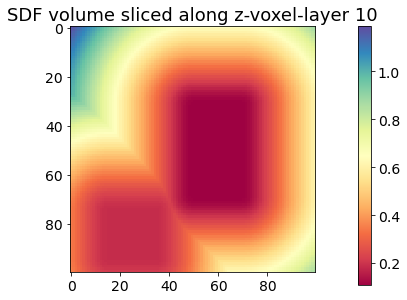

In [22]:
show_single_layer(sdf_matr, 10)

#### Convert to stl

In [16]:
mesh = env_builder.render_voxel_view(sdf_matr, return_mesh=True)
_ = mesh.export('mesh.stl')

#### Load mesh

In [6]:
mesh = trimesh.load_mesh('mesh.stl')
scene = trimesh.Scene()
scene.add_geometry(mesh)
scene.show()

#### Generate SDF from mesh

In [7]:
res = mesh_to_voxels(mesh, voxel_resolution=64)

In [ ]:
mesh2 = env_builder.render_voxel_view(res, return_mesh=True)
scene = trimesh.Scene()
scene.add_geometry(mesh2)
scene.show()

_, mesh2.export('mesh3.stl')